# Investigating alternate dissipation/time-integration schemes for SWE
*Connor Duffin*
In this note we look at different time-integration schemes for SWE and do some empirical checks on their convergence properties. We look at four time-integration methods:

* BDF2
* Theta scheme: $\theta = 0.5$ (Crank-Nicolson).
* Theta scheme: $\theta = 0.6$.
* Theta scheme: $\theta = 1.0$ (Implicit Euler).

For a generic spatially discretised PDE with state $\mathbf{u}$ these schemes are given by the iterations:

1. $\theta$-method:
$$
  \frac{\mathbf{u}^{n + 1} - \mathbf{u}^n}{\Delta_t} = F(\theta \mathbf{u}^{n + 1} + (1 - \theta) \mathbf{u}^n)
$$
2. BDF2:
$$
  \frac{3}{2}
  \frac{\mathbf{u}^{n + 1} - \frac{4}{3}\mathbf{u}^n + \frac{1}{3}
  \mathbf{u}^{n - 1}}{\Delta_t} = F(\mathbf{u}^{n + 1})
$$

where $F(\cdot)$ is the discretised representation of the PDE RHS. Setting $\theta$ equal to the values given above gives the appropriate updating scheme.

In this note, we also also look at a simplified version of the SWE in which the damping term is given by a Laplacian operator. I.e., the SWE in strong form are given by:

\begin{align*}
  \partial_t u + u \cdot \nabla u + g \nabla h - (\nu + \nu_t) \nabla^2 u &= 0, \\
  \partial_t h + \nabla \cdot ((H + h) u) &= 0.
\end{align*}

We have included the additional coefficient $\nu_t > 0$ to parameterise the additional viscous effects that are due to turbulent effects. We will see that the choice of this parameter results in changes to the stability of the numerical schemes.

First we load up some libraries:


In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../scripts")

from swe import ShallowTwo

def plot_fields_curr(swe, t):
    x_vertices = swe.mesh.coordinates()
    n_vertices = len(x_vertices)
    du_vec = swe.du.compute_vertex_values()
    u1, u2, h = (du_vec[:n_vertices], du_vec[n_vertices:(2 * n_vertices)],
                 du_vec[(2 * n_vertices):])

    x, y = x_vertices[:, 0], x_vertices[:, 1]

    fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(9, 6))

    im = axs[0].tricontourf(x, y, u1, 64)
    axs[0].set_title(r"$u_1$")
    cbar = fig.colorbar(im, ax=axs[0])

    im = axs[1].tricontourf(x, y, u2, 64)
    axs[1].set_title(r"$u_2$")
    cbar = fig.colorbar(im, ax=axs[1])

    im = axs[2].tricontourf(x, y, h, 64, cmap="coolwarm")
    axs[2].set_title(r"$h$")
    cbar = fig.colorbar(im, ax=axs[2])

    for ax in axs:
        ax.set_ylabel(r"$y$")
    axs[-1].set_xlabel(r"$x$")


def plot_quiver_curr(swe, t):
    x_vertices = swe.mesh.coordinates()
    n_vertices = len(x_vertices)
    du_vec = swe.du.compute_vertex_values()
    u1, u2, h = (du_vec[:n_vertices], du_vec[n_vertices:(2 * n_vertices)],
                 du_vec[(2 * n_vertices):])

    x, y = x_vertices[:, 0], x_vertices[:, 1]
    fig, ax = plt.subplots(1, 1, figsize=(9, 4))
    ax.quiver(x, y, u1, u2)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title(f"Velocity field at time t = {t:.5f}")


def read_model(model_output_file, idx=None):
    swe = ShallowTwo(mesh="../mesh/channel-piggott.xdmf",
                     control={
                         "dt": 1e-3,
                         "theta": 1,
                         "integrate_continuity_by_parts": True,
                         "simulation": "cylinder",
                         "laplacian": False,
                         "les": True
                     })

    x_vertices = swe.mesh.coordinates()
    x, y = x_vertices[:, 0], x_vertices[:, 1]
    n_vertices = len(x_vertices)

    checkpoint = fe.HDF5File(swe.mesh.mpi_comm(), model_output_file, "r")

    if idx is None:
        idx_final = checkpoint.attributes("/du")["count"]
        vec_name = f"/du/vector_{idx_final - 1}"
    else:
        vec_name = f"/du/vector_{idx}"

    checkpoint.read(swe.du, vec_name)  # read into du
    t = checkpoint.attributes(vec_name)["timestamp"]
    return swe, t


def extract_fields(swe, n_vertices):
    du_vec = swe.du.compute_vertex_values()
    u1, u2, h = (du_vec[:n_vertices], du_vec[n_vertices:(2 * n_vertices)],
                 du_vec[(2 * n_vertices):])
    return (u1, u2, h)


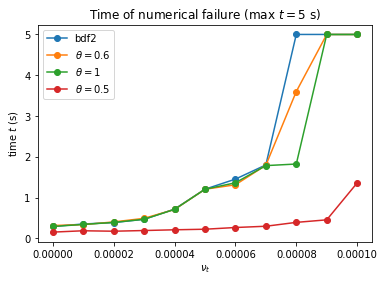

In [4]:
%matplotlib inline
nus = np.linspace(0, 1e-4, 11)

times_bdf2 = []
times_theta6 = []
times_cn = []
times_euler = []

for nu in nus:
    times_bdf2.append(
        read_model(f"../outputs/swe-channel-laplacian-nu_t-{nu:.4e}-bdf2.h5")[1])
    times_theta6.append(
        read_model(f"../outputs/swe-channel-laplacian-nu_t-{nu:.4e}-theta-1.00.h5")[1])
    times_cn.append(
        read_model(f"../outputs/swe-channel-laplacian-nu_t-{nu:.4e}-theta-0.50.h5")[1])
    times_euler.append(
        read_model(f"../outputs/swe-channel-laplacian-nu_t-{nu:.4e}-theta-0.60.h5")[1])

plt.plot(nus, times_bdf2, "o-", label="bdf2")
plt.plot(nus, times_theta6, "o-", label=r"$\theta = 0.6$")
plt.plot(nus, times_euler, "o-", label=r"$\theta = 1$")
plt.plot(nus, times_cn, "o-", label=r"$\theta = 0.5$")

plt.legend()
plt.xlabel(r"$\nu_t$")
plt.ylabel(r"time $t$ (s)")
plt.title("Time of numerical failure (max $t = 5$ s)")
plt.show()


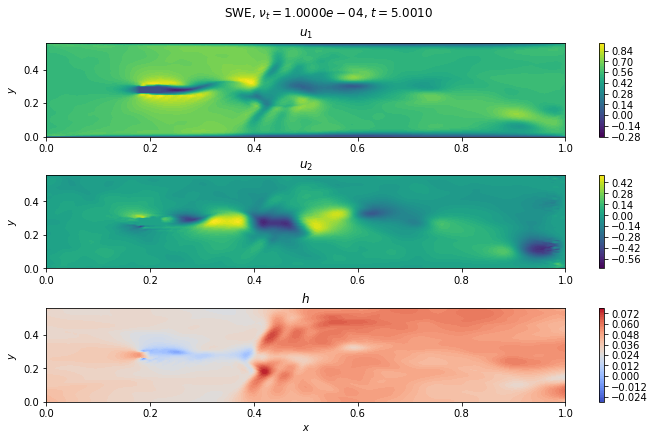

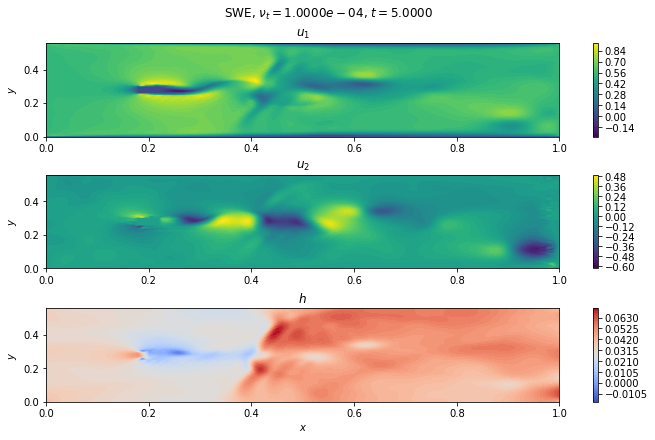

In [5]:
swe_bdf2, t_bdf2 = read_model(f"../outputs/swe-channel-laplacian-nu_t-{1e-4:.4e}-bdf2.h5")
plot_fields_curr(swe_bdf2, t_bdf2)
plt.suptitle(fr"SWE, $\nu_t = {1e-4:.4e}$, $t = {t_bdf2:.4f}$")
plt.show()

swe_cn6, t_cn6 = read_model(f"../outputs/swe-channel-laplacian-nu_t-{1e-4:.4e}-theta-0.60.h5")

plot_fields_curr(swe_cn6, t_cn6)
plt.suptitle(fr"SWE, $\nu_t = {1e-4:.4e}$, $t = {t_cn6:.4f}$")
plt.show()


In [6]:
print(fe.errornorm(swe_cn6.du, swe_bdf2.du) / fe.norm(swe_bdf2.du))


*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.16051206246724203


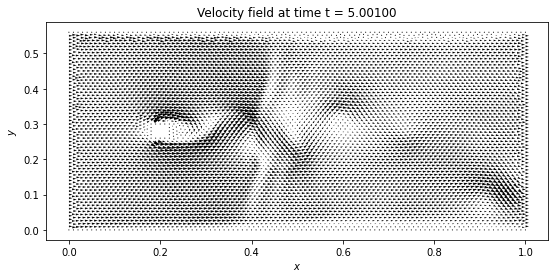

In [7]:
swes, times = [], []

for nu in nus:
    swe_temp, t_temp = read_model(
        f"../outputs/swe-channel-laplacian-nu_t-{nu:.4e}-bdf2.h5")
    swes.append(swe_temp)
    times.append(t_temp)

plot_quiver_curr(swes[-1], times[-1])

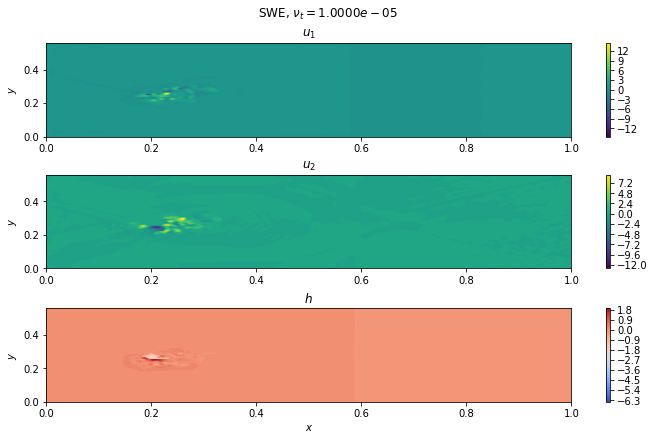

In [8]:
idx = 1
plot_fields_curr(swes[idx], times[idx])
plt.suptitle(fr"SWE, $\nu_t = {nus[idx]:.4e}$")
plt.show()

In [9]:
print(fe.errornorm(swes[-1].du, swes[-2].du) / fe.norm(swes[-2].du))


*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.38467539158316255


Now we test these solutions against those computed with the LES --- somewhat of a "gold standard" comparison. To do this comparison we visually check how they compare and then compute a relative $L^2$ error.

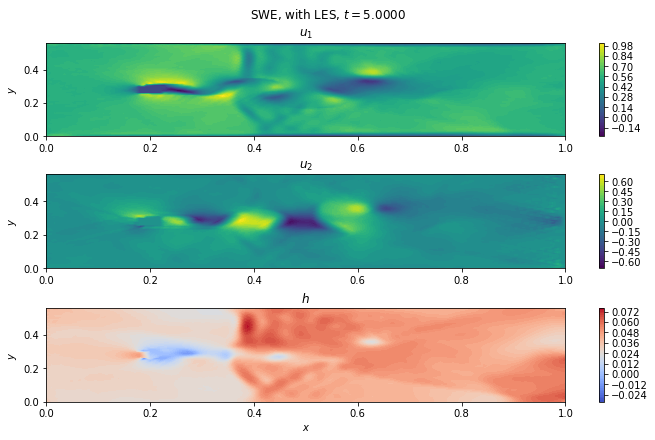

In [10]:
swe_les, t_les = read_model(f"../outputs/swe-channel-les-theta-0.60.h5", 5000)

plot_fields_curr(swe_les, t_les)
plt.suptitle(fr"SWE, with LES, $t = {t_les:.4f}$")
plt.show()

In [11]:
nu = nus[-2]
swe_approx, t_approx = read_model(
    f"../outputs/swe-channel-laplacian-nu_t-{nu:.4e}-bdf2.h5", 4999)

assert t_approx == t_les

x_vertices = swe_approx.mesh.coordinates()
n_vertices = len(x_vertices)

_, _, h_les = extract_fields(swe_les, n_vertices)
_, _, h_approx = extract_fields(swe_approx, n_vertices)

print(np.linalg.norm(h_les - h_approx) / np.linalg.norm(h_les))

0.20414305926757562


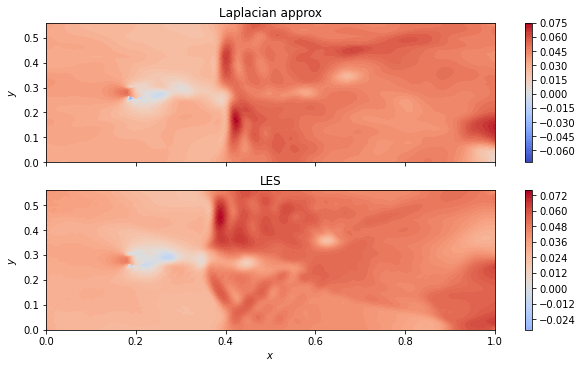

In [12]:
titles = [fr"Laplacian approx", fr"LES"]
swes_plot = [swes[-2], swe_les]
fields = []

for swe in swes_plot:
    x_vertices = swe.mesh.coordinates()
    n_vertices = len(x_vertices)
    du_vec = swe.du.compute_vertex_values()
    u1, u2, h = (du_vec[:n_vertices], du_vec[n_vertices:(2 * n_vertices)],
                 du_vec[(2 * n_vertices):])

    x, y = x_vertices[:, 0], x_vertices[:, 1]

    fields.append(h)

def get_min_max(x):
    return np.amin(x), np.amax(x)

h_min, h_max = get_min_max(np.asarray(fields))
n_plot = len(fields)

fig, axs = plt.subplots(n_plot, 1, constrained_layout=True, figsize=(8, 5), sharex=True, sharey=True)

for i, h in enumerate(fields):
    im = axs[i].tricontourf(x, y, h, 64, cmap="coolwarm", vmin=h_min, vmax=h_max)
    axs[i].set_title(titles[i])
    cbar = fig.colorbar(im, ax=axs[i])

for ax in axs:
    ax.set_ylabel(r"$y$")
axs[-1].set_xlabel(r"$x$")
plt.show()
plt.close()